# Programming for Data Science and Artificial Intelligence

## CIFAR-10

The <a href='https://en.wikipedia.org/wiki/CIFAR-10'>CIFAR-10</a> dataset is similar to MNIST, except that instead of one color channel (grayscale) there are three channels (RGB).

Where an MNIST image has a size of (1,28,28), CIFAR images are (3,32,32). There are 10 categories an image may fall under:
1. airplane
2. automobile
3. bird
4. cat
5. deer
6. dog
7. frog
7. horse
8. ship
9. truck

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import seaborn as sn  # for heatmaps
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

## 1. ETL: Load the CIFAR-10 dataset
PyTorch makes the CIFAR-10 train and test datasets available through <a href='https://pytorch.org/docs/stable/torchvision/index.html'><tt><strong>torchvision</strong></tt></a>. The first time they're called, the datasets will be downloaded onto your computer to the path specified. From that point, torchvision will always look for a local copy before attempting another download.<br>The set contains 50,000 train and 10,000 test images.

Refer to the previous section for explanations of transformations, batch sizes and <a href='https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader'><tt><strong>DataLoader</strong></tt></a>.

In [2]:
transform  = transforms.ToTensor()

train_data = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
test_data  = datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: ToTensor()

### Create loaders

In [5]:
torch.manual_seed(101)  # for reproducible results

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=10, shuffle=False)

### Define strings for labels
We can call the labels whatever we want, so long as they appear in the order of 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'. Here we're using 5-character labels padded with spaces so that our reports line up later.

In [6]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

We don't want to use the variable name "class" here, as it would overwrite Python's built-in keyword.

## 2. EDA: View a batch of images

Label: [    1     5     8     1     6     1     6     3     7     9]
Class:    car   dog  ship   car  frog   car  frog   cat horse truck


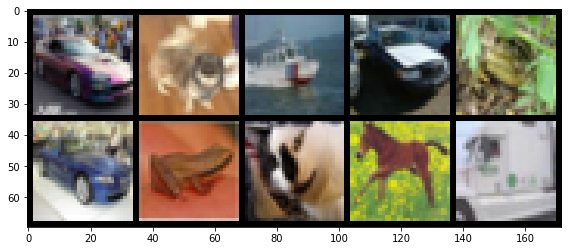

In [7]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

# Grab the first batch of 10 images
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

# Print the images
im = make_grid(images, nrow=5)  # the default nrow is 8
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## 3. Training / Modeling

Our first convolutional layer will have 3 input channels, 6 output channels, a kernel size of 3 (resulting in a 3x3 filter), and a stride length of 1 pixel.<br>These are passed in as <tt>nn.Conv2d(3,6,3,1)</tt>

In [8]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)  # changed from (1, 6, 5, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(6*6*16, 120)   # changed from (4*4*16) to fit 32x32 images with 3x3 filters
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 6*6*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return X

<div class="alert alert-info"><strong>Why <tt>(6x6x16)</tt> instead of <tt>(5x5x16)</tt>?</strong><br>
With MNIST the kernels and pooling layers resulted in (((28−2)/2)−2)/2=5.5 which rounds down to 5 pixels per side.<br>
With CIFAR the result is (((32-2)/2)-2)/2 = 6.5 which rounds down to 6 pixels per side.</div>

In [9]:
torch.manual_seed(101)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Including the bias terms for each layer, the total number of parameters being trained is:<br>

$\quad\begin{align}(3\times6\times3\times3)+6+(6\times16\times3\times3)+16+(576\times120)+120+(120\times84)+84+(84\times10)+10 &=\\
162+6+864+16+69120+120+10080+84+840+10 &= 81,302\end{align}$<br>

In [10]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [11]:
count_parameters(model)

   162
     6
   864
    16
 69120
   120
 10080
    84
   840
    10
______
 81302


### Define loss function & optimizer

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Train the model

This time we'll feed the data directly into the model without flattening it first.

In [13]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%1000 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/50000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch: 1000 [ 10000/50000]  loss: 1.74820971  accuracy:  24.160%
epoch:  0  batch: 2000 [ 20000/50000]  loss: 2.36250257  accuracy:  30.840%
epoch:  0  batch: 3000 [ 30000/50000]  loss: 1.33114505  accuracy:  34.670%
epoch:  0  batch: 4000 [ 40000/50000]  loss: 2.00900984  accuracy:  37.557%
epoch:  0  batch: 5000 [ 50000/50000]  loss: 0.83030498  accuracy:  40.006%
epoch:  1  batch: 1000 [ 10000/50000]  loss: 1.27267063  accuracy:  51.050%
epoch:  1  batch: 2000 [ 20000/50000]  loss: 1.45015550  accuracy:  51.915%
epoch:  1  batch: 3000 [ 30000/50000]  loss: 1.46286118  accuracy:  52.610%
epoch:  1  batch: 4000 [ 40000/50000]  loss: 0.90122890  accuracy:  52.947%
epoch:  1  batch: 5000 [ 50000/50000]  loss: 0.91321534  accuracy:  53.258%
epoch:  2  batch: 1000 [ 10000/50000]  loss: 1.02271748  accuracy:  56.770%
epoch:  2  batch: 2000 [ 20000/50000]  loss: 0.88789332  accuracy:  57.080%
epoch:  2  batch: 3000 [ 30000/50000]  loss: 1.02723885  accuracy:  57.343%
epoch:  2  b

### Optional: Save the model

In [14]:
torch.save(model.state_dict(), 'models/CIFAR10-CNN-Model.pt')

### Plot the loss and accuracy comparisons

In [15]:
train_losses = [loss.item() for loss in train_losses]
test_losses  = [loss.item() for loss in test_losses]

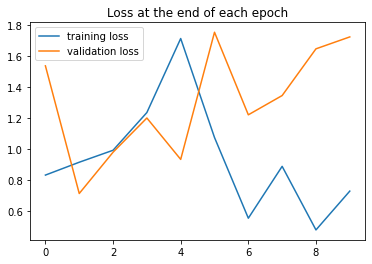

In [16]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

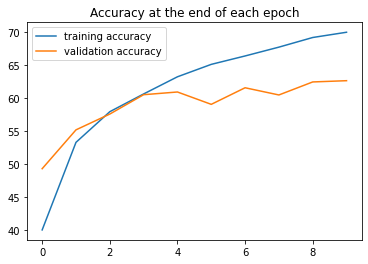

In [17]:
plt.plot([t/500 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct],  label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

## 4. Inference / Testing

In [18]:
print(test_correct) # contains the results of all 10 epochs
print()
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%') # print the most recent result as a percent

[tensor(4927), tensor(5515), tensor(5754), tensor(6047), tensor(6088), tensor(5901), tensor(6152), tensor(6043), tensor(6240), tensor(6259)]

Test accuracy: 62.590%


This is not as impressive as with MNIST, which makes sense. We would have to adjust our parameters to obtain better results.<br>
Still, it's much better than the 10% we'd get with random chance!

### Display the confusion matrix

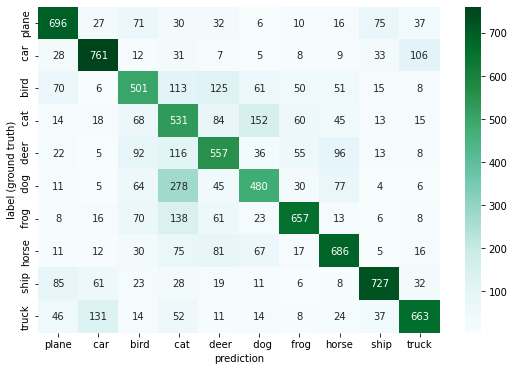

In [19]:
# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

## 5. Error Analysis
We can track the index positions of "missed" predictions, and extract the corresponding image and label. We'll do this in batches to save screen space.

In [20]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
        
# Display the number of misses
len(misses)

3741

In [21]:
# Display the first 8 index positions
misses[:8]

array([    4,     6,     8,    17,    19,    24,    31,    33])

In [22]:
# Set up an iterator to feed batched rows
r = 8   # row size
row = iter(np.array_split(misses,len(misses)//r+1))

Now that everything is set up, run and re-run the cell below to view all of the missed predictions.<br>
Use <kbd>Ctrl+Enter</kbd> to remain on the cell between runs. You'll see a <tt>StopIteration</tt> once all the misses have been seen.

Index: [    4     6     8    17    19    24    31    33]
Label: [    6     1     3     7     6     5     5     5]
Class:   frog   car   cat horse  frog   dog   dog   dog

Guess: [    4     5     2     3     3     4     4     3]
Class:   deer   dog  bird   cat   cat  deer  deer   cat


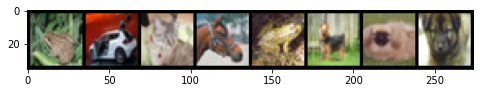

In [23]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

nextrow = next(row)
lbls = y_test.index_select(0,torch.tensor(nextrow)).numpy()
gues = predicted.index_select(0,torch.tensor(nextrow)).numpy()
print("Index:", nextrow)
print("Label:", lbls)
print("Class: ", *np.array([class_names[i] for i in lbls]))
print()
print("Guess:", gues)
print("Class: ", *np.array([class_names[i] for i in gues]))

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(8,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

<div class="alert alert-info"><font color=blue><h3>Optional: Load a Saved Model</h3>
In the event that training the ConvolutionalNetwork takes too long, you can load a trained version by running the following code:</font>
<pre style='background-color:rgb(217,237,247)'>
model2 = ConvolutionalNetwork()
model2.load_state_dict(torch.load('models/CIFAR10-CNN-Model-master.pt'))
model2.eval()</pre>
</div>

In [24]:
# Instantiate the model and load saved parameters
model2 = ConvolutionalNetwork()
model2.load_state_dict(torch.load('models/CIFAR10-CNN-Model.pt'))
model2.eval()

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [25]:
# Evaluate the saved model against the test set
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model2(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
        
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 6259/10000 =  62.590%


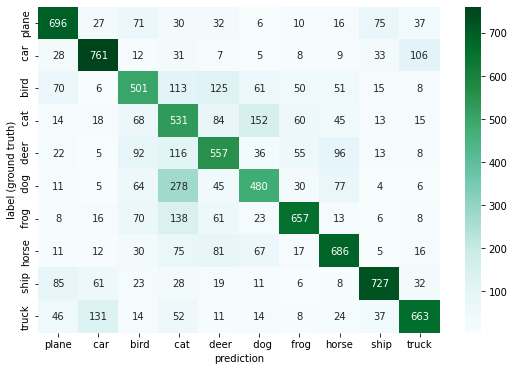

In [26]:
# Display the confusion matrix as a heatmap
arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();